<a href="https://colab.research.google.com/github/BC-Chang/ms-net-workshop/blob/main/Permeability_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Velocity Field Prediction Using CNNs

In this notebook, we will adopt a Neural Network to predict the velocity field from a binary image and post-process to estimate the permeability.

We will go through a general machine learning workflow:
1. Data acquisition and preprocessing
2. Data selection
3. Build* and train the model
4. Evaluate model performance


Remember... it is always a tradeoff between model bias and model variance!

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Bias_and_variance_contributing_to_total_error.svg/1280px-Bias_and_variance_contributing_to_total_error.svg.png" width="400">

> **Bias:** Low model complexity leads to high bias — model does not pay attention to training data and oversimplifies the model

> **Variance:** Complex models lead to high variance — model pays too much attention to the training data and does not generalize well to new data.

We need to find a balance between bias and variance that minimizes the total error!

### We need to first import some packages.

There are several machine learning libraries. Common packages include Tensorflow/Keras and PyTorch.

We will play around with both.

In [1]:
# @title Importing libraries and downloading data (run me first)
%%capture

!pip install git+https://github.com/je-santos/livelossplot

import os
import sys
import random

# Importing the numerical and viz libs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon
import seaborn as sns
from IPython.display import clear_output
import ipywidgets as widgets
from IPython.display import display

# Importing utilities libs
import glob
from PIL import Image

# Importing the ML libs
import sklearn
import tensorflow as tf
from tensorflow import keras
#keras.backend.set_epsilon = 1e-4


# more libraries
!pip install scikit-fmm
import skfmm
import scipy.ndimage as sc
import time

!pip install porespy
import porespy as ps


from livelossplot import PlotLossesKeras
from livelossplot.plot_losses  import MatplotlibPlot

import warnings
warnings.simplefilter("ignore")

# function to calculate the relative error
def calc_errror(y,y_pred,epsilon=1e-4, reduction = 'mean'):
    rel_error = np.abs(y-y_pred)/np.clip(np.abs(y),a_min=epsilon,a_max=None)*100
    if reduction == 'mean':
        return rel_error.mean()
    elif reduction == 'none':
        return rel_error()


try:
  os.mkdir('numpys')
except:
  pass


# !git clone https://github.com/je-santos/PoreFlow-Net.git
# !mv PoreFlow-Net/ilustrations/numpys.zip numpys/numpys.zip
# os.chdir('numpys')


# from zipfile import ZipFile
# with ZipFile('numpys.zip', 'r') as zipObj:
#    # Extract all the contents of zip file in current directory
#    zipObj.extractall()
# os.chdir('..')


ERROR:openpnm:PARDISO solver not installed, run `pip install pypardiso`. Otherwise, simulations will be slow. Apple M chips not supported.


## Problem 1: Flow through a Tube



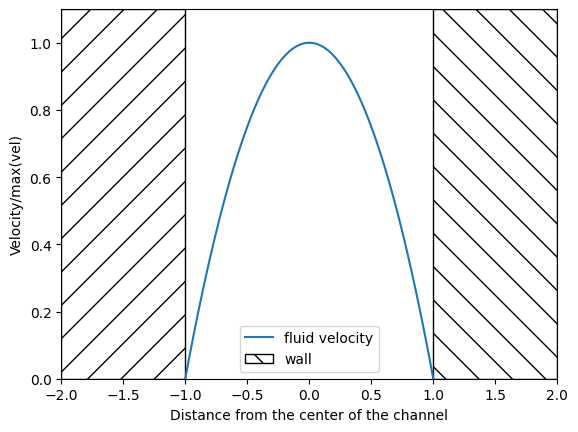

In [2]:
""""This is our target function, the neural network doesn't know this"""

def vel_profile(x):
    return 1-x**2

x_vel = np.linspace(-1,1,100)
y_vel = vel_profile(x_vel)

fig, ax = plt.subplots(1)
ax.plot(x_vel,y_vel)
ax.axes.add_patch(Polygon([[1, 0], [2, 0], [2, 1.1],[1, 1.1]], closed=True,
                      fill=False, hatch='\ '))
ax.axes.add_patch(Polygon([[-1, 0], [-2, 0], [-2, 1.1],[-1, 1.1]], closed=True,
                      fill=False, hatch='/'))
plt.xlim([-2,2])
plt.ylim([0,1.1]);
plt.xlabel('Distance from the center of the channel')
plt.ylabel('Velocity/max(vel)');
plt.legend(['fluid velocity','wall']);

## Training our First Neural Network

We'll start with the simplest neural network architecture. A model with one neuron, which is equivalent to a linear regression:

$y=w_1x+b_1$

We will use mean square error:

$MSE(y\_pred,y)=\frac{1}{N}\sum(y\_pred-y)^2$

and the ADAM optimizer:

$\theta_{t+1} = \theta_{t}-LR\frac{v_t}{\sqrt{s_t+\epsilon}}\cdot g_t$

Where $v_t$ and $s_t$ are the first and second gradient moments, respectively

In [3]:
model_name = 'nn_class'
rnd_seed   = np.sum( [ord(letter) for letter in model_name] )*123123
np.random.seed( rnd_seed )    # we use this num as the rnd seed for numpy

# Defining our default parameters
loss_f  = 'mse'
optim   = keras.optimizers.Adam
LR      = 0.1
metrics = ['MAPE'] # Mean average percentage error

# Setting up our model using the keras library
# Number of parameters in dense layers = inputs * outputs + biases
linear_model = keras.Sequential([keras.layers.Dense(1,input_shape=[1])])
linear_model.compile(loss=loss_f, optimizer=optim(), metrics=metrics)
linear_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

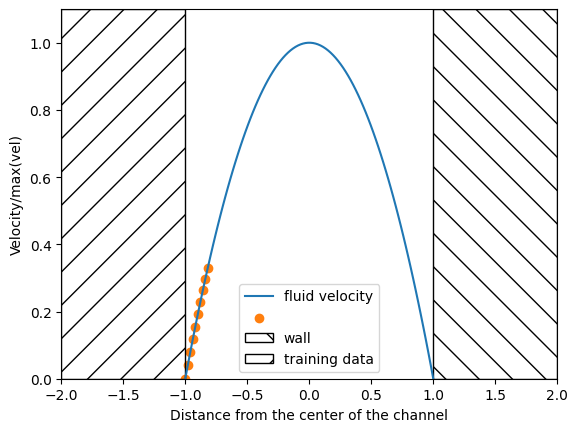

In [4]:
fig, ax = plt.subplots(1)
ax.plot(   x_vel,     y_vel)
ax.scatter(x_vel[:10],y_vel[:10],c='tab:orange')
ax.axes.add_patch(Polygon([[1, 0], [2, 0], [2, 1.1],[1, 1.1]], closed=True,
                      fill=False, hatch='\ '))
ax.axes.add_patch(Polygon([[-1, 0], [-2, 0], [-2, 1.1],[-1, 1.1]], closed=True,
                      fill=False, hatch='/'))
plt.xlim([-2,2])
plt.ylim([0,1.1]);
plt.xlabel('Distance from the center of the channel')
plt.ylabel('Velocity/max(vel)');
plt.legend(['fluid velocity','','wall','training data']);

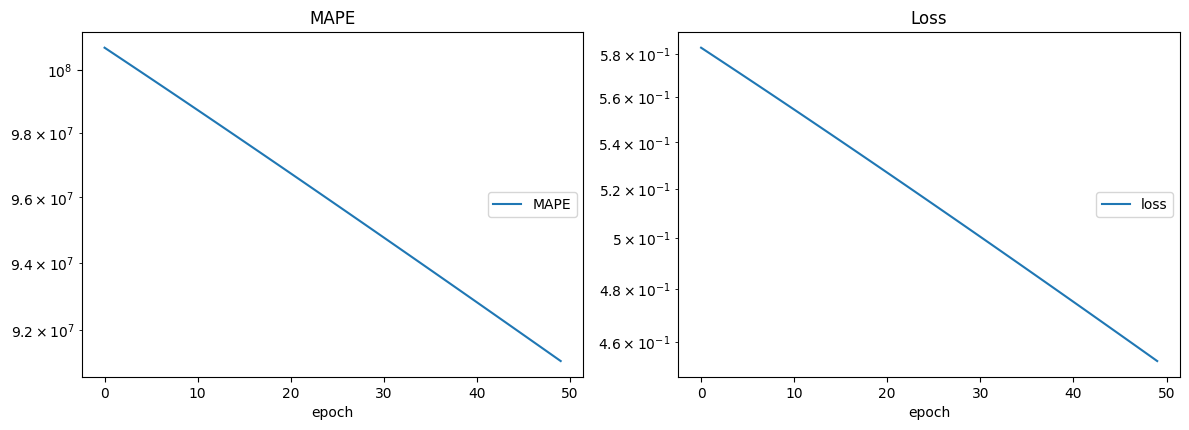

MAPE
	MAPE             	 (min: 91082704.000, max: 100730552.000, cur: 91082704.000)
Loss
	loss             	 (min:    0.453, max:    0.583, cur:    0.453)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - MAPE: 91082704.0000 - loss: 0.4530   
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


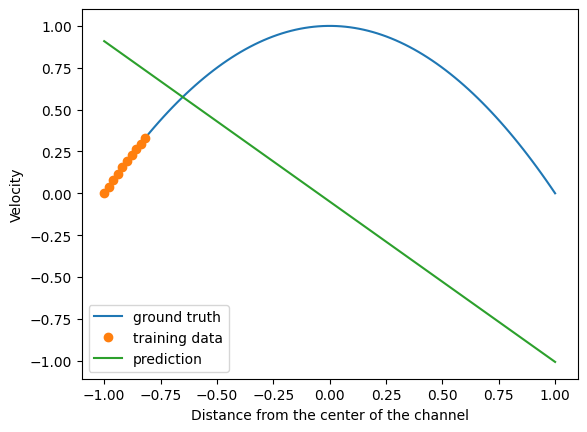

In [5]:
linear_model.fit(x=x_vel[:10], y=y_vel[:10], callbacks=PlotLossesKeras(), epochs=50, validation_split=0)

y_pred = linear_model.predict(x=x_vel)

plt.plot(x_vel,y_vel)
plt.plot(x_vel[:10], y_vel[:10],'o')
plt.plot(x_vel, y_pred)

plt.legend(['ground truth','training data','prediction'])
plt.xlabel('Distance from the center of the channel')
plt.ylabel('Velocity');

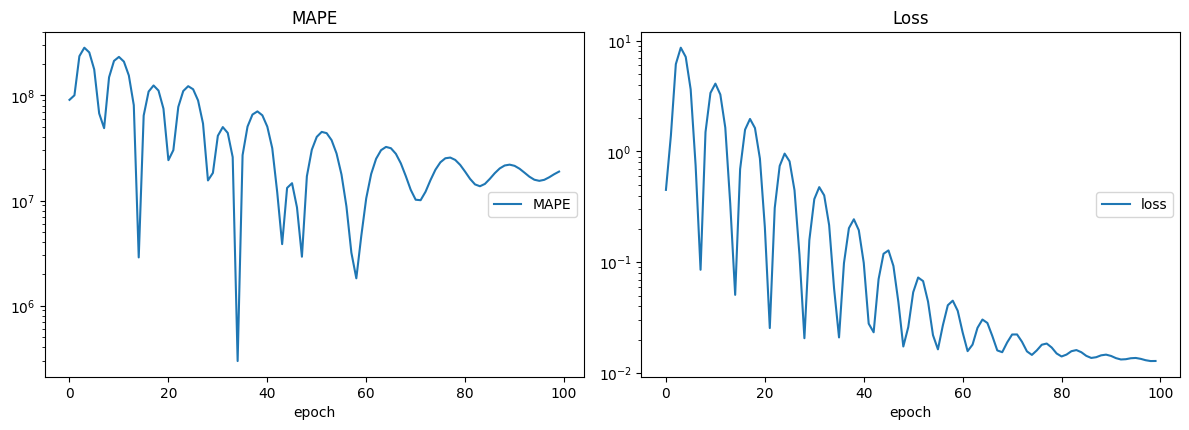

MAPE
	MAPE             	 (min: 296445.375, max: 285086784.000, cur: 18869156.000)
Loss
	loss             	 (min:    0.013, max:    8.626, cur:    0.013)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step - MAPE: 18869156.0000 - loss: 0.0129


In [6]:
# Let's adjust the learning rate and continue training
linear_model.optimizer.learning_rate.assign(1.0)

linear_model.fit(x=x_vel[:10], y=y_vel[:10], callbacks=PlotLossesKeras(), epochs=100, validation_split=0)

# A good place to stop is when loss < 1e-5

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


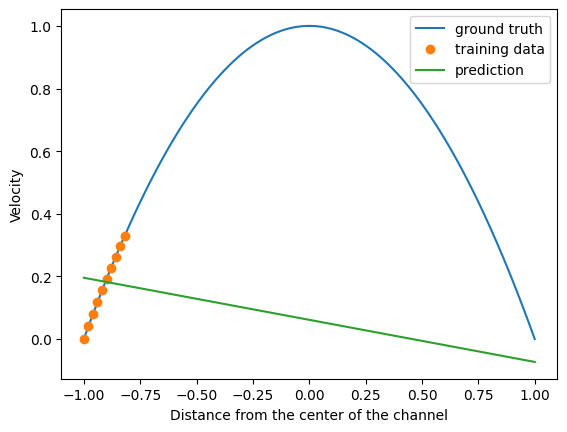

In [7]:
y_pred = linear_model.predict(x=x_vel)

plt.plot(x_vel,y_vel)
plt.plot(x_vel[:10], y_vel[:10],'o')
plt.plot(x_vel, y_pred)

plt.legend(['ground truth','training data','prediction'])
plt.xlabel('Distance from the center of the channel')
plt.ylabel('Velocity');

### Obviously, this is not great...


A number of issues with our model:

1. We do not have a representative dataset
2. Our model is not complex enough

  2a. We do not implement any nonlinearity to our model
3. We are blindly trying to fit a model to our data


#### A More Representative Dataset

One method shown here is to randomly shuffle the training data.

*Disclaimer:* Random shuffle is not always best! Sometimes it's better to engineer the training data to be more representative.



Text(0, 0.5, 'Velocity')

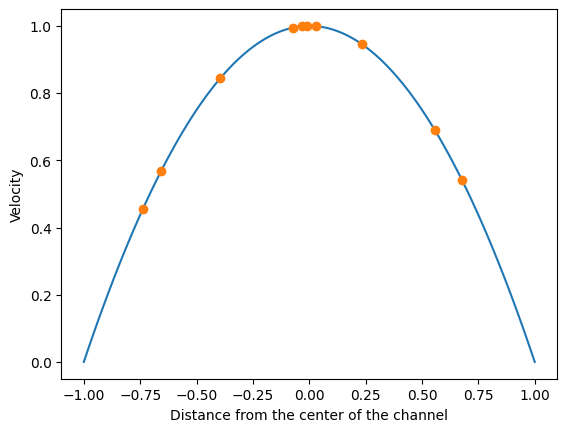

In [16]:
# Select a random set of points on the curve
IDs = np.arange( x_vel.shape[0] )
np.random.shuffle( IDs )
x_train = x_vel[IDs[:10]]
y_train = y_vel[IDs[:10]]

plt.plot(x_vel,y_vel)
plt.plot(x_train, y_train,'o')

plt.xlabel('Distance from the center of the channel')
plt.ylabel('Velocity')

### Non-Linearity

We can add some non-linearity in the form of the SELU activation function. We also add a little bit more complexity with the model by adding a few more neurons

SELU (Scaled Exponential Linear Unit) Activation Function

<img src="https://www.researchgate.net/profile/Alberto-Marchisio/publication/328878703/figure/fig2/AS:691988286423047@1541994272922/Behavior-of-ReLU-ELU-and-SELU-activation-functions.ppm" width="600">



In [22]:
# Define a non_linear model
non_linear_model = keras.Sequential()
non_linear_model.add(keras.layers.Dense(2,activation='selu',input_shape=(1,)))
non_linear_model.add(keras.layers.Dense(1,activation='selu'))
non_linear_model.compile(loss=loss_f,optimizer=optim(), metrics=metrics)
non_linear_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                     │ (None, 2)                   │               4 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7 (28.00 B)

 Trainable params: 7 (28.00 B)

 Non-trainable params: 0 (0.00 B)

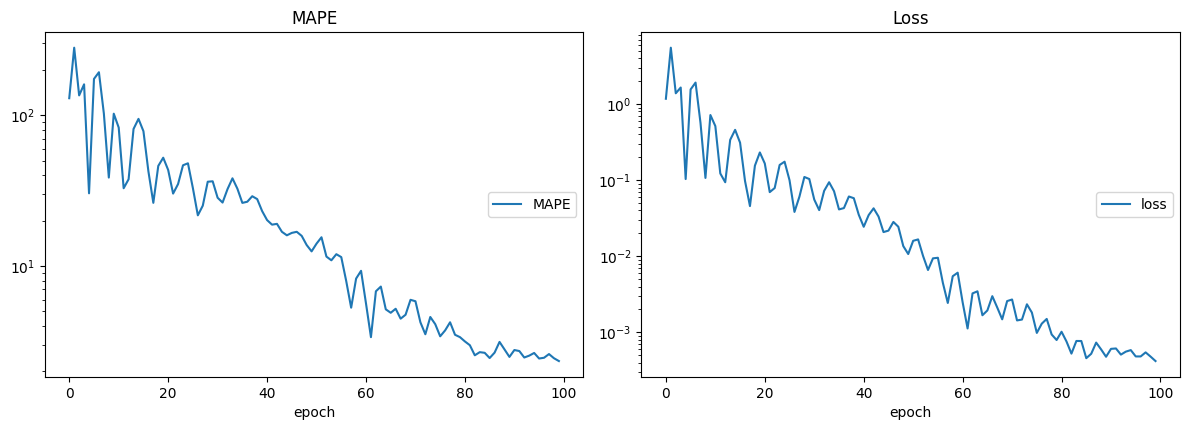

MAPE
	MAPE             	 (min:    2.343, max:  280.785, cur:    2.343)
Loss
	loss             	 (min:    0.000, max:    5.509, cur:    0.000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - MAPE: 2.3435 - loss: 4.1904e-04  


In [23]:
# Set our learning rate and start training our model
non_linear_model.optimizer.learning_rate.assign(1)
non_linear_model.fit(x=x_train, y=y_train, callbacks=PlotLossesKeras(), epochs=100, validation_split=0)

# A good place to stop is when MSE < 1E-4

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


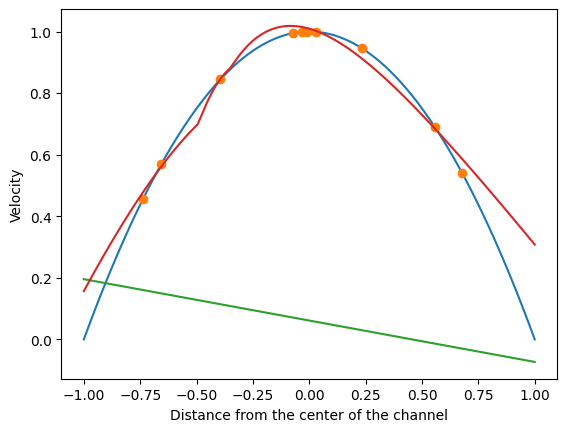

In [24]:
y_pred_NL = non_linear_model.predict(x=x_vel)

plt.plot(x_vel,y_vel)
plt.plot(x_train, y_train,'o')
plt.plot(x_vel, y_pred)
plt.plot(x_vel, y_pred_NL)


plt.xlabel('Distance from the center of the channel')
plt.ylabel('Velocity');

### This prediction is somewhat better, but still not great!

We, as scientists and engineers, know more than the model does. In this example, we know that flow through a pipe should have a parabolic velocity profile. We can add this to our network architecture.

This often saves on model complexity — faster training, more generalizability

In [25]:
def build_linear_model(input_shape):
    inputs = keras.layers.Input(shape=input_shape)
    path   = keras.layers.Lambda(lambda x: tf.square(x))(inputs)
    path   = keras.layers.Dense(1,activation='linear')(path)
    return keras.models.Model(inputs, path)

linear_model = build_linear_model(input_shape=(1,))
linear_model.summary()
linear_model.compile(loss=loss_f,optimizer=optim(), metrics=metrics)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

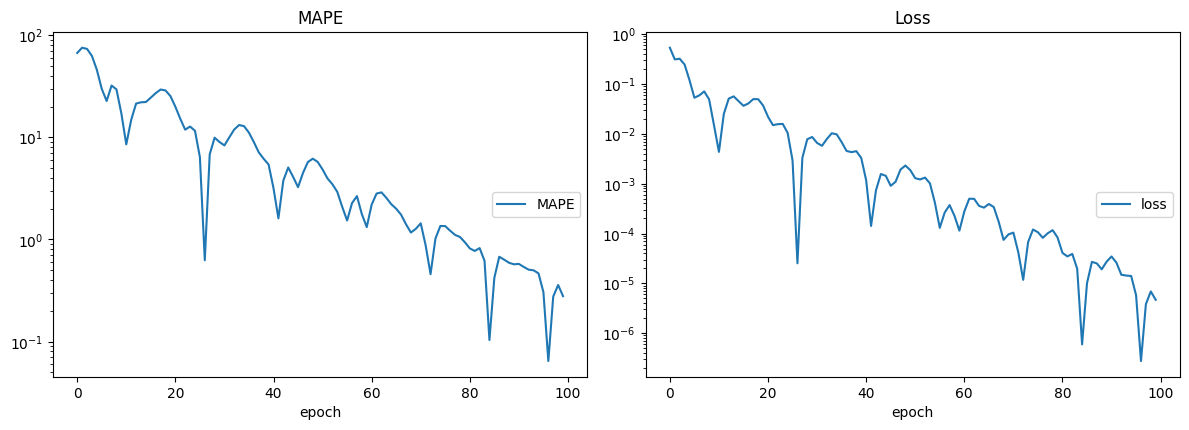

MAPE
	MAPE             	 (min:    0.064, max:   75.370, cur:    0.278)
Loss
	loss             	 (min:    0.000, max:    0.533, cur:    0.000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - MAPE: 0.2781 - loss: 4.6763e-06   


In [26]:
linear_model.optimizer.learning_rate.assign(0.5)
linear_model.fit(x=x_train, y=y_train, callbacks=PlotLossesKeras(), epochs=100, validation_split=0)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
The weight of the neuron is -1.009922742843628 with a bias of 1.0026187896728516


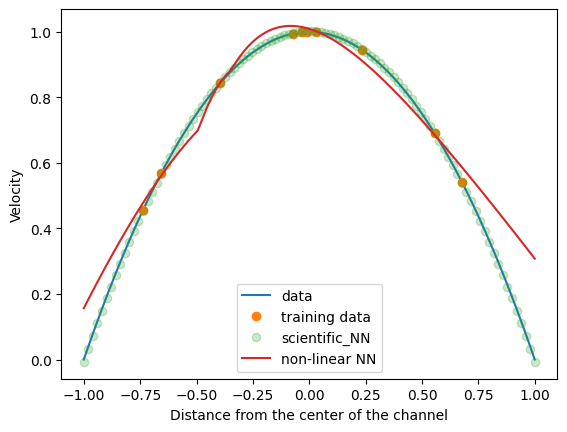

In [27]:
y_pred = linear_model.predict(x=x_vel)
plt.plot(x_vel,y_vel)
plt.plot(x_train, y_train,'o')
plt.plot(x_vel, y_pred, 'o', alpha=0.25)
plt.plot(x_vel, y_pred_NL)

plt.legend(['data','training data','scientific_NN','non-linear NN'])
plt.xlabel('Distance from the center of the channel')
plt.ylabel('Velocity');

print(f'The weight of the neuron is {linear_model.weights[0].numpy()[0][0]} with a bias of {linear_model.weights[1].numpy()[0]}')

## Problem 2: Permeability Prediction

In this example, we will try to predict the velocity field from a binary image using [MS-Net](https://doi.org/10.1007/s11242-021-01617-y).

MS-Net was built on Pytorch, another ML package. The syntax is a bit different but the basic concepts are the same.

<img src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs11242-021-01617-y/MediaObjects/11242_2021_1617_Fig3_HTML.png?as=webp">




In [1]:
#@title Run this cell to clone the MS-Net Repo and import some packages

from tqdm.notebook import trange
from tqdm import tqdm_notebook


for i in trange(1, desc='Install and import workshop packages'):
  # Our workshop repository
  !git clone https://github.com/BC-Chang/ms-net-workshop.git &> /dev/null

  import os
  os.chdir('ms-net-workshop')  # Set working directory

  # Data loading package
  !pip install hdf5storage &> /dev/null

  # Install Live Loss Plot Package
  !pip install git+https://github.com/je-santos/livelossplot &> /dev/null

  !pip install wget &> /dev/null


  # Pytorch packages
  import torch
  import torch.nn as nn
  from torch.optim import Adam, SGD
  from torch.optim.lr_scheduler import ReduceLROnPlateau# as reduceLR

  import numpy as np
  import wget
  from hdf5storage import loadmat # Data loading
  from scipy.ndimage.morphology import distance_transform_edt # Euclidean Distance function

  # Network packages
  from network import MS_Net
  from pore_utils import scale_tensor
  from network_tools import get_masks


  # Visualization packages
  import matplotlib.pyplot as plt
  import matplotlib.image as mpimg
  from matplotlib.patches import Ellipse, Polygon
  import seaborn as sns
  from IPython.display import clear_output
  import ipywidgets as widgets
  from IPython.display import display
  from livelossplot import PlotLosses

Install and import workshop packages:   0%|          | 0/1 [00:00<?, ?it/s]

<ipython-input-1-433036ef1ce2>:32: DeprecationWarning: Please import `distance_transform_edt` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import distance_transform_edt # Euclidean Distance function


## Load data from the Digital Rocks Portal

We will use data from the [3D Dataset of Simulations](https://www.digitalrocksportal.org/projects/372) stored on the Digital Rocks Portal. This dataset contains LBM and electrical simulations and have been preprocessed for more efficient workflows.

The entire dataset contains over 200 samples, here we will only use a couple.

In [2]:
x = loadmat('/content/ms-net-workshop/example_data/374_01_04_256_1_bin.mat')['bin']
y = loadmat('/content/ms-net-workshop/example_data/374_01_04_256_1_uz.mat')['uz']

# Invert x such that pore space = 1
x = -1*x + 1

(-0.5, 255.5, 255.5, -0.5)

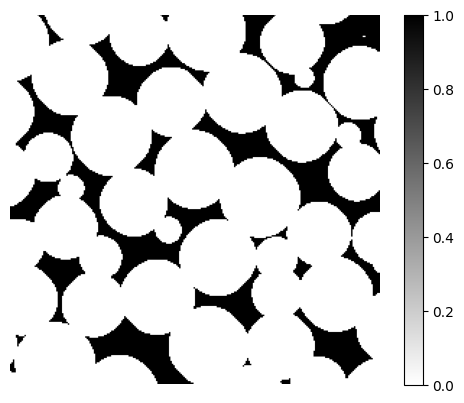

In [30]:
# Plot Binary
plt.imshow(x[:,54,:], vmin=0, vmax=1, cmap='binary');
plt.colorbar()
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

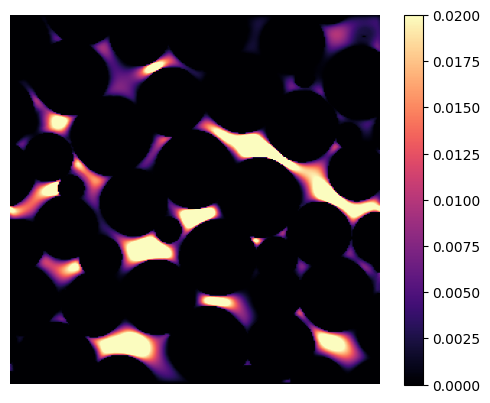

In [31]:
plt.imshow(y[:,54,:], vmin=0, vmax=0.02, cmap='magma');
plt.colorbar()
plt.axis('off')

But wait! Remember we know something about how velocity behaves

We calculate the Euclidean distance transform for a more direct relationship to the velocity field. We could add as many input features as we want.

(-0.5, 255.5, 255.5, -0.5)

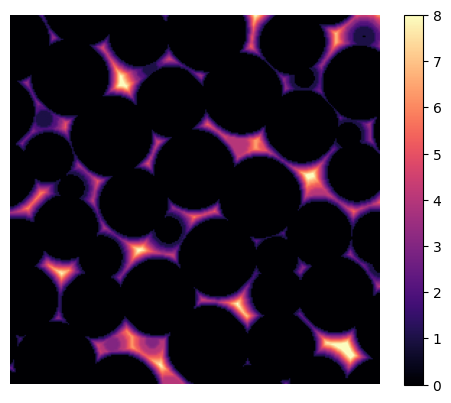

In [32]:
# Calculate Euclidean distance
x = distance_transform_edt(x)
plt.imshow(x[:,54,:], vmax=8, cmap='magma');
plt.colorbar()
plt.axis('off')

In [4]:
# This function normalizes the given data, converts to a Torch tensor,
# and downscales image to specified number of scales

def preprocess_data(data, num_scales=2):
  # Normalize data
  data = data / np.amax(data)
  # data = (data - np.amin(data)) / (np.amax(data) - np.amin(data))

  # Convert data into torch tensor
  data = torch.as_tensor(data, dtype=torch.float32)

  # Add dimensions to torch tensor
  data = data[None, None, :, :, :]

  # Compute data on different scales
  ds_data = []
  ds_data.append(data)
  for i in range( num_scales-1 ):
    ds_data.append( scale_tensor( ds_data[-1], scale_factor=1/2, mode='nearest') )

  data = ds_data[::-1] # Returns the reversed list (smallest images first)

  return data

In [34]:
num_scales = 3

x_n = preprocess_data(x, num_scales)
y_n = preprocess_data(y, num_scales)

# Get masks
masks = get_masks(x_n[-1], scales=num_scales)

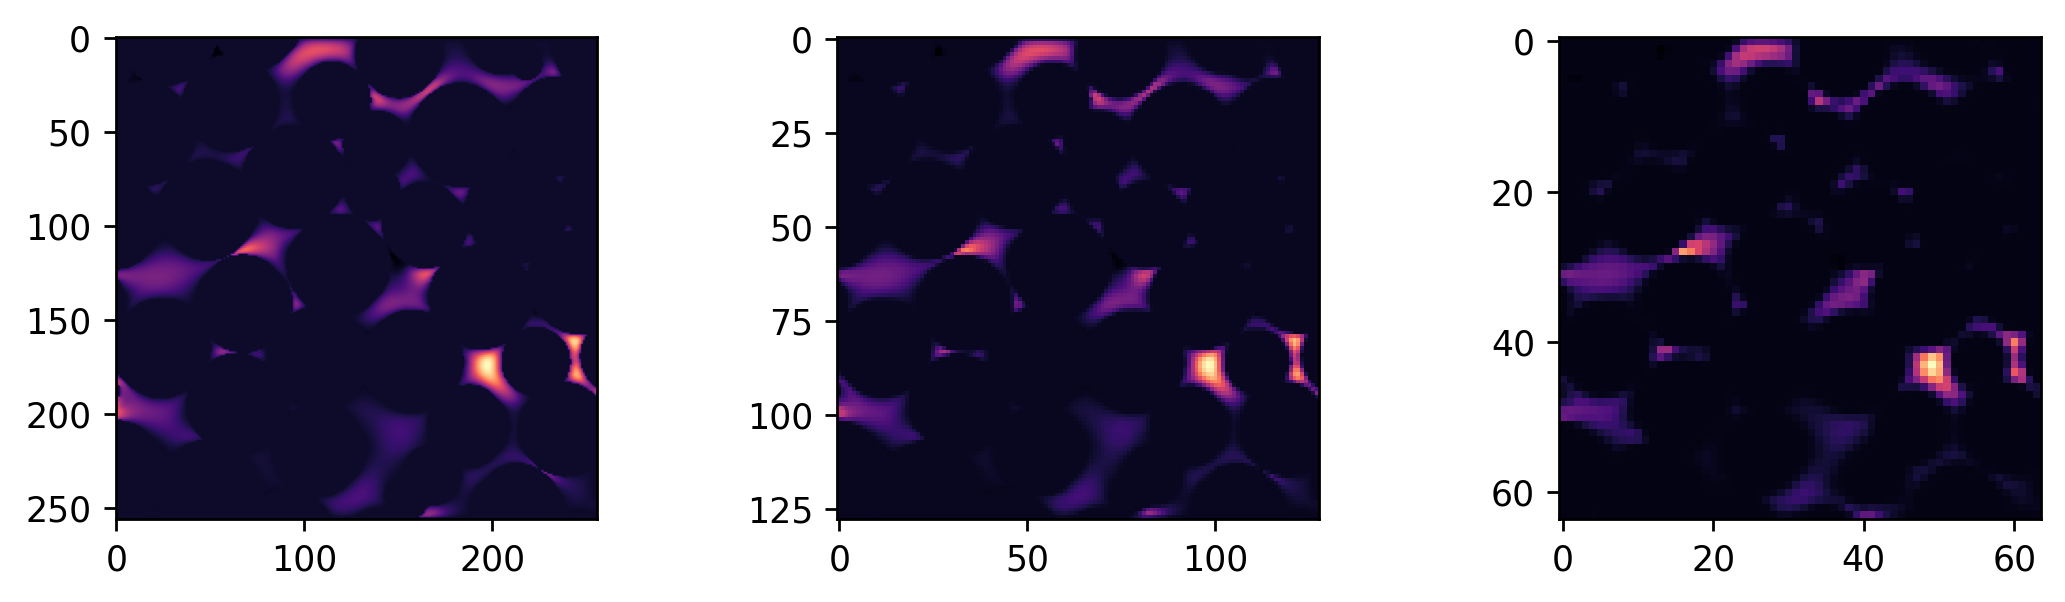

In [35]:
fig = plt.figure(figsize=(11,8), dpi=250)

for i in range(num_scales):
  plt.subplot(1,num_scales,i+1)
  my_slice = int(y_n[-i-1].size()[-1]/2)
  plt.imshow(y_n[-i-1][0,0,:,my_slice,:], cmap='magma')


fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.5, hspace=0.05)

Text(0.5, 1.0, 'Velocity in Z')

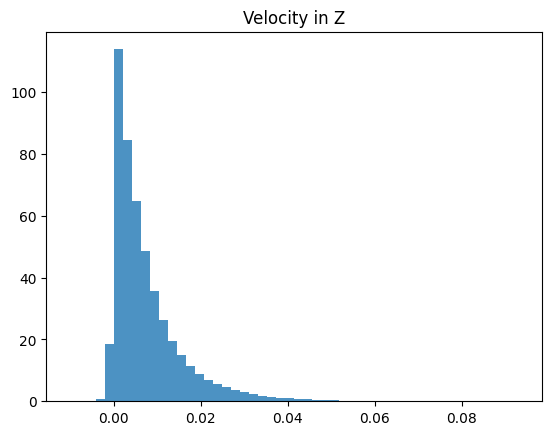

In [36]:
# plt.subplot(1,2,1)

plt.hist(y[x>0].ravel(), 50, density='True', alpha=0.8)
plt.title('Velocity in Z')

In [47]:
device = 'cuda' if torch.cuda.is_available() else "cpu" # Include this line to train on GPUs

bin_model = MS_Net(
    num_scales = num_scales,
    num_features = 1,
    num_filters = 6,
    device = device,
    summary = True
)

Filters per model: [96, 24, 6]

 Here is a summary of your MS-Net (test1): 
 ModuleList(
  (0): get_model(
    (head): ConvBlock3D(
      (conv): Conv3d(1, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (i_norm): InstanceNorm3d(96, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (CeLU): CELU(alpha=1.0)
    )
    (body): Sequential(
      (block1): ConvBlock3D(
        (conv): Conv3d(96, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (i_norm): InstanceNorm3d(96, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (CeLU): CELU(alpha=1.0)
      )
      (block2): ConvBlock3D(
        (conv): Conv3d(96, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (i_norm): InstanceNorm3d(96, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (CeLU): CELU(alpha=1.0)
      )
      (block3): ConvBlock3D(
        (conv): Conv3d(96, 96, kernel_size=(3, 3, 3), stride=(1,

In [48]:
# Set up training parameters
learning_rate = 1e-4
epochs = 100
model_name = 'workshop_bin_model'
optimizer = Adam(bin_model.parameters(), lr=learning_rate)  # Adam optimizer
# scheduler  = ReduceLROnPlateau( optimizer, verbose=True, threshold=1e-6, min_lr=1e-6, patience = 25 )  # Learning rate scheduler
loss_f = nn.MSELoss()  # MSE loss function
loss = 1e9  # Initialize value of loss
best_loss = 1e10
liveloss = PlotLosses()

In [49]:
# Send data to GPU
bin_model = bin_model.to(device)
masks = [m.to(device) for m in masks]
x_n = [x.to(device) for x in x_n]
y_n = [y.to(device) for y in y_n]

In [11]:
def calc_loss(y_pred, y, loss_f, log):

    loss = 0
    y_var = y[-1].var()
    for scale, [y_hat,yi] in enumerate(zip(y_pred, y)):
        loss_scale = loss_f(y_hat,yi)#/y_var
        loss += loss_scale
        prefix = f'scale_{scale}_'
        log[prefix + 'loss'] =  loss_scale.item()

    log['loss'] = loss.item()

    return loss, log

## Training Loop

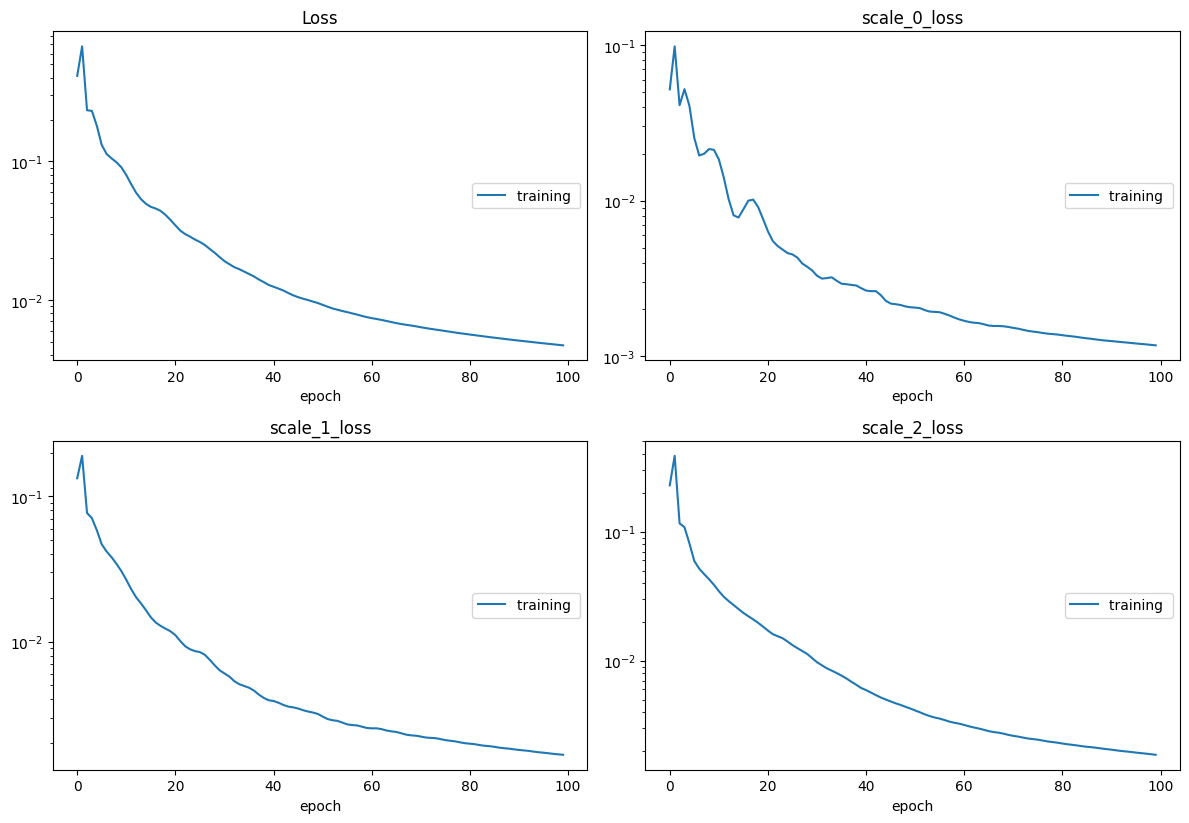

Loss
	training         	 (min:    0.005, max:    0.675, cur:    0.005)
scale_0_loss
	training         	 (min:    0.001, max:    0.098, cur:    0.001)
scale_1_loss
	training         	 (min:    0.002, max:    0.190, cur:    0.002)
scale_2_loss
	training         	 (min:    0.002, max:    0.387, cur:    0.002)


In [51]:
for epoch in range(epochs):
    logs={}

    # clear the gradients
    optimizer.zero_grad()

    # compute the model output
    y_hat = bin_model(x_n, masks)

    loss_prev = loss
    loss, logs = calc_loss(y_hat, y_n, loss_f, logs)

    # credit assignment
    loss.backward()

    # update model weights
    optimizer.step()

    liveloss.update(logs)
    liveloss.send()

    #     print('Saving model...')
    #     torch.save(net, f'{model_name}.pth')

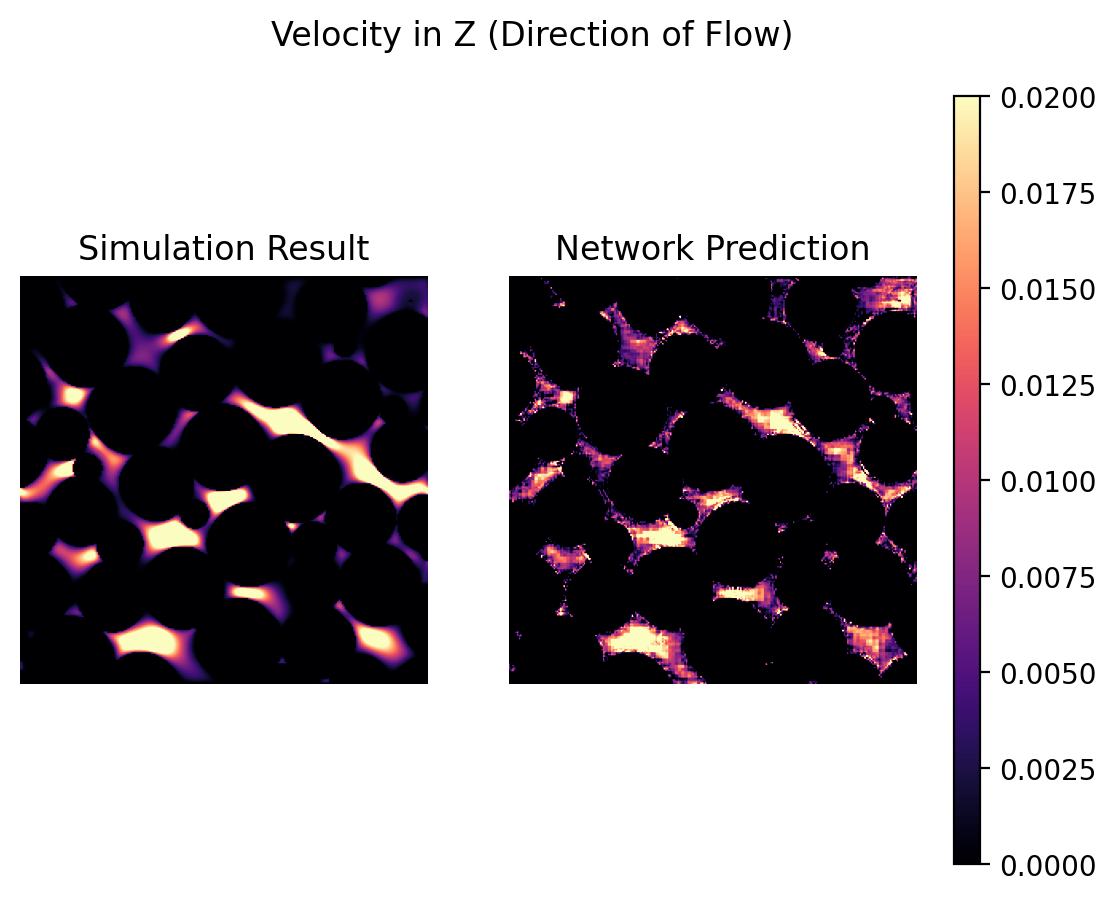

In [52]:
#%% Evaluate Model
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=200)

y_n = [y.cpu() for y in y_n]
axes[0].set_axis_off()
im = axes[0].imshow(y_n[-1][0,0,:,54,:]*np.amax(y), vmin=0, vmax=0.02, cmap='magma')
axes[0].title.set_text('Simulation Result')

y_hat = [yh.cpu() for yh in y_hat]
pred = y_hat[-1].detach()

axes[1].set_axis_off()
im = axes[1].imshow(pred[0,0,:,54,:]*np.amax(y), vmin=0, vmax=0.02, cmap='magma')
axes[1].title.set_text('Network Prediction')


plt.suptitle('Velocity in Z (Direction of Flow)')
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.2, hspace=0.01)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
# plt.show()

# plt.figure(figsize=(8,5))
# plt.axis('off')
# im = plt.imshow(np.abs(y_n[-1][0,0,:,54,:] - pred[0,0,:,54,:]), vmin=0, vmax=0.02)#/y_n[-1][0,0,:,54,:] * 100, vmin=0, vmax=100)
# plt.title('Absolute Error')
# plt.colorbar()

## To test the model, we need to load in and preprocess a test sample in the same way as before.

In [53]:
x_test = loadmat('/content/ms-net-workshop/example_data/374_07_01_256_1_bin.mat')['bin']
y_test = loadmat('/content/ms-net-workshop/example_data/374_07_01_256_1_uz.mat')['uz']

# Invert x such that pore space = 1
x_test = -1*x_test + 1

# Calculate Euclidean Distance Transform
x_test = distance_transform_edt(x_test)

# Normalize the data and convert to a Torch tensor
x_test_n = preprocess_data(x_test, num_scales)
y_test_n = preprocess_data(y_test, num_scales)

# Get masks
masks_test = get_masks(x_test_n[-1], scales=num_scales)

x_test_n = [x.to(device) for x in x_test_n]
y_test_n = [y.to(device) for y in y_test_n]
masks_test = [m.to(device) for m in masks_test]

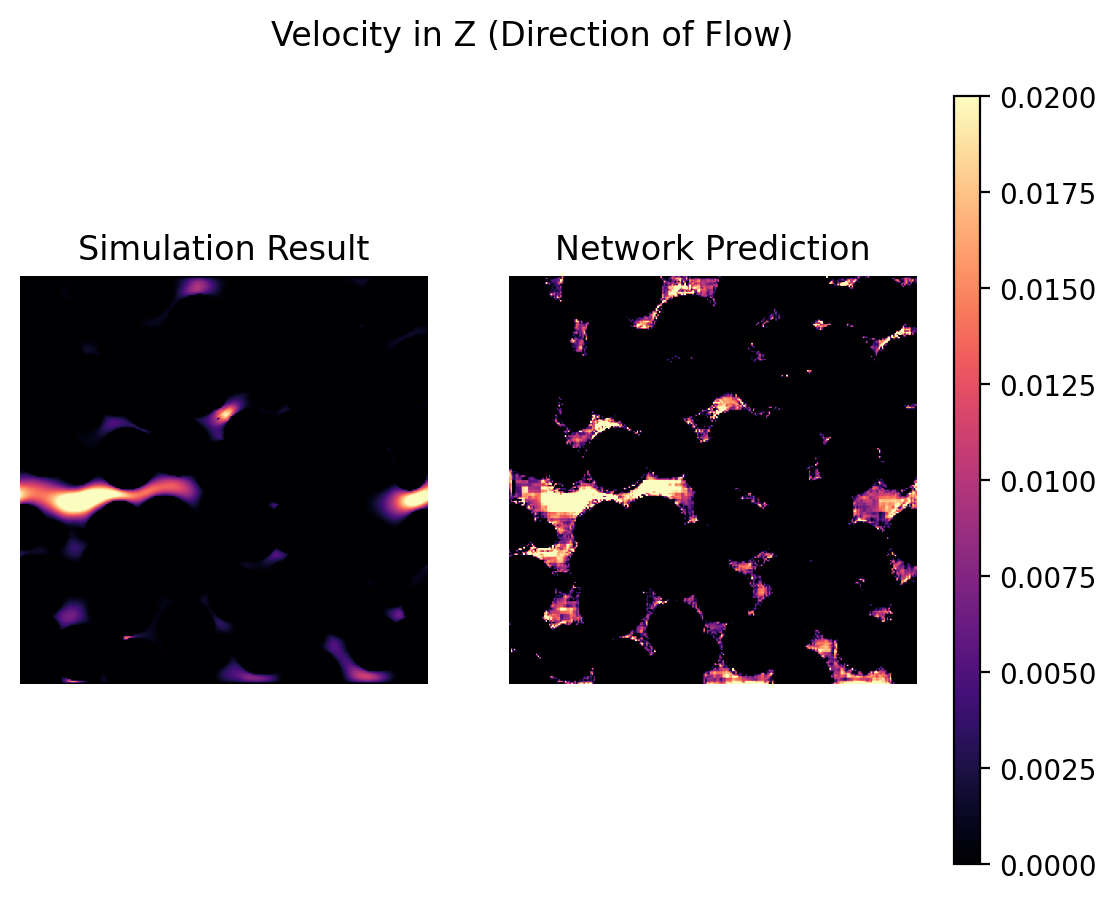

In [54]:
# Make a prediction on test data
y_test_hat = bin_model(x_test_n, masks_test)
loss, _ = calc_loss(y_test_hat, y_test_n, loss_f, {})

# Plot the prediction
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=200)

y_test_n = [y.cpu() for y in y_test_n]
axes[0].set_axis_off()
im = axes[0].imshow(y_test_n[-1][0,0,:,54,:]*np.amax(y), vmin=0, vmax=0.02, cmap='magma')
axes[0].title.set_text('Simulation Result')

y_test_hat = [yh.cpu() for yh in y_test_hat]
pred = y_test_hat[-1].detach()

axes[1].set_axis_off()
im = axes[1].imshow(pred[0,0,:,54,:]*np.amax(y), vmin=0, vmax=0.02, cmap='magma')
axes[1].title.set_text('Network Prediction')


plt.suptitle('Velocity in Z (Direction of Flow)')
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.2, hspace=0.01)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)

## Computing Permeability From the Predicted Field

To compute the permeability from the prediction, we can compare the calculated flux to Darcy's law in the same fashion as in LBM simulations.

$$ k = \frac{\bar{u} \mu L}{\Delta P} $$

where $\bar{u}$ is the mean of the velocity field in the flow direction.This only works if we know how the simulations were set up. Often, it's more convenient to simply compare the mean velocities of the predicted vs. actual velocity fields when evaluating our model.

$$ \frac{\hat{k}}{k} = \frac{\hat{\bar{u}}}{\bar{u}} $$





k_hat / k = 4.3552


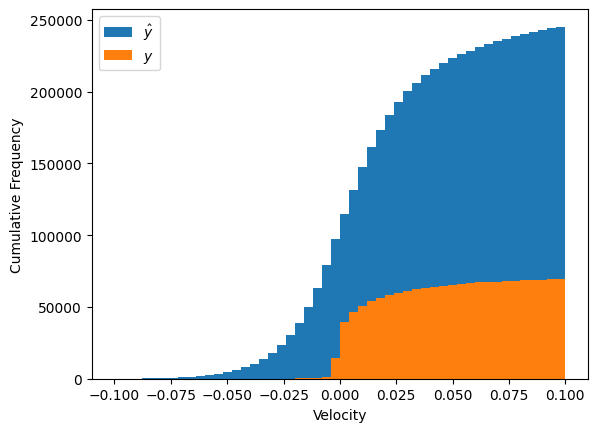

In [78]:
k_hat = torch.mean(y_test_hat[0])
k = torch.mean(y_test_n[0])

print(f"k_hat / k = {(k_hat / k).item():.4f}")

plt.hist(y_test_hat[0][y_test_hat[0] != 0].detach().numpy().flatten(),
         bins=50, range=(-0.1, 0.1), label="$\hat{y}$", cumulative=True)
plt.hist(y_test_n[0][y_test_n[0] != 0].detach().numpy().flatten(), bins=50, range=(-0.1, 0.1), label="$y$",
         cumulative=True)
plt.ylabel("Cumulative Frequency")
plt.xlabel("Velocity")
plt.legend()
# plt.hist(y_test_hat[0].detach().numpy().flatten(), bins=50, range=(-0.1, 0.2))

## What if we wanted multiple samples?
### For time's sake, we only used one training sample.

To add more, simply supply a list of the samples you want to include.

Because of hardware constraints, it's often difficult to pass in the entire training set at once. Instead, we can do **gradient accumulation**

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
datapath='/content/ms-net-workshop/example_data'

samples = ["374_01_04_256_1", "374_06_01_256_1"]
num_scales = 3

x = [loadmat(f'{datapath}/{sample}_bin.mat')['bin'] for sample in samples]
y = [loadmat(f'{datapath}/{sample}_uz.mat')['uz'] for sample in samples]

x = [distance_transform_edt(bin_sample) for bin_sample in x]

# Normalize the data and convert to a Torch tensor
x_n = [preprocess_data(x_i, num_scales) for x_i in x]
y_n = [preprocess_data(y_i, num_scales) for y_i in y]


masks = [get_masks(x_i[-1], scales=num_scales) for x_i in x_n]
masks = [[m.to(device, non_blocking=True) for m in masks_i] for masks_i in masks]

x_n = [[x.to(device) for x in x_i] for x_i in x_n]
y_n = [[y.to(device) for y in y_i] for y_i in y_n]


### Validation data is loaded in the same way

In [7]:
val = ["374_07_01_256_1"]
x_val = [loadmat(f'{datapath}/{sample}_bin.mat')['bin'] for sample in samples]
y_val = [loadmat(f'{datapath}/{sample}_uz.mat')['uz'] for sample in samples]

x_val = [distance_transform_edt(bin_sample) for bin_sample in x_val]

# Normalize the data and convert to a Torch tensor
x_val_n = [preprocess_data(x_i, num_scales) for x_i in x_val]
y_val_n = [preprocess_data(y_i, num_scales) for y_i in y_val]


masks_val = [get_masks(x_i[-1], scales=num_scales) for x_i in x_val_n]
masks_val = [[m.to(device, non_blocking=True) for m in masks_i] for masks_i in masks_val]

x_val_n = [[x.to(device) for x in x_i] for x_i in x_val_n]
y_val_n = [[y.to(device) for y in y_i] for y_i in y_val_n]

### Setup for our model remains the same

In [13]:
multisample_model = MS_Net(
    num_scales = num_scales,
    num_features = 1,
    num_filters = 6,
    device = device,
    summary = False
)

# Set up training parameters
learning_rate = 1e-4
epochs = 100
model_name = 'workshop_multisample_model'
optimizer = Adam(multisample_model.parameters(), lr=learning_rate)  # Adam optimizer
batchsize = 2
# scheduler  = ReduceLROnPlateau( optimizer, verbose=True, threshold=1e-6, min_lr=1e-6, patience = 25 )  # Learning rate scheduler
loss_f = nn.MSELoss()  # MSE loss function
loss = 1e9  # Initialize value of loss
best_loss = 1e10
liveloss = PlotLosses()


# Send model to GPU
multisample_model = multisample_model.to(device)


Filters per model: [96, 24, 6]


### Training Loop

In [14]:
for epoch in range(epochs):
    logs={}

    # clear the gradients
    optimizer.zero_grad()

    # Gradient accumulation
    for i in range(len(samples)):
        print(f'Sample {i}:')
        # compute the model output
        y_hat = multisample_model(x_n[i], masks[i])

        # Calculate loss
        loss, loss_scales = calc_loss(y_hat[i], y_n[i], masks[i], loss_f, logs)
        loss.backward()
        print('Loss: %r\n' %loss)

        # Only update model parameters every batchsize steps
        if (i+1) % batchsize == 0:
          optimizer.step()
          optimizer.zero_grad()

    # If you wanted validation data, you would input it here similarly to training
    # But you would not perform backpropagation or gradient updates
    for i in range(len(val)):
      y_hat_val = multisample_model(x_val_n[i], masks_val[i])
      loss, _ = calc_loss(y_hat_val[i], y_val_n[i], masks_val[i], loss_f, {})

    liveloss.update(logs)
    liveloss.send()

Sample 0:


OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB. GPU 